In [57]:
# Import and init h2o lib. Running on java
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 hours 8 mins
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_paaske_2eiu45
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.467 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [58]:
# Reading csv to h2o dataframe 
col_types_train = {
 'chain_name': 'enum',
 'mall_name': 'enum',
 'revenue': 'numeric',
 #'lv1': 'enum',
 'lv2': 'enum',
 'lv3': 'enum',
 'total_nbr_people': 'int',
 'nbr_people_per_store_in_grunnkrets': 'numeric',
 #'counts_gr_lv2': 'numeric',
 #'counts_municipality_lv2': 'numeric',
 #'busstops_within_50m': 'numeric',
 #'busstops_within_100m': 'numeric',
 #'busstops_within_400m': 'numeric',
 #'busstops_within_800m': 'numeric',
 'busstops_within_1500m': 'numeric',
 #'num_stores_within_100m_and_same_lvl2': 'numeric',
 'num_stores_within_500m_and_same_lvl2': 'numeric',
 #'num_stores_within_1km_and_same_lvl2': 'numeric',
 #'num_stores_within_5km_and_same_lvl2': 'numeric',
 #'num_stores_within_10km_and_same_lvl2': 'numeric',
 'num_stores_within_20km_and_same_lvl2': 'numeric',
 'closest_competitor_lv2': 'numeric',
 'mean_revenue_lv3' : 'numeric',
 'mean_revenue_lv2' : 'numeric',
 'median_revenue_lv3' : 'numeric',
 'median_revenue_lv2' : 'numeric',
 'mean_revenue_chain' : 'numeric',
 'median_revenue_lv4' : 'numeric',
 'mean_revenue_lv4' : 'numeric'
 #'num_stores_within_100m_and_same_lvl3': 'numeric',
 #'num_stores_within_500m_and_same_lvl3': 'numeric',
 #'num_stores_within_1km_and_same_lvl3': 'numeric',
 #'num_stores_within_5km_and_same_lvl3': 'numeric',
 #'num_stores_within_10km_and_same_lvl3': 'numeric',
 #'num_stores_within_20km_and_same_lvl3': 'numeric',
 #'closest_competitor_lv3': 'numeric',
 #'municipality_size_group': 'enum',
 #'mean_revenue_for_municipality_size_group': 'numeric',
 #'median_revenue_for_municipality_size_group': 'numeric',
 #'st_dev_of_revenue_for_municipality_size_group': 'numeric',
 #'municipality_rev_group_lv2': 'numeric',
 #'mean_revenue_for_municipality_rev_group_lv2': 'numeric'
 }

col_types_test = {
 'chain_name': 'enum',
 'mall_name': 'enum',
 #'lv1': 'enum',
 'lv2': 'enum',
 'lv3': 'enum',
 'total_nbr_people': 'int',
 'nbr_people_per_store_in_grunnkrets': 'numeric',
 #'counts_gr_lv2': 'numeric',
 #'counts_municipality_lv2': 'numeric',
 #'busstops_within_50m': 'numeric',
 #'busstops_within_100m': 'numeric',
 #'busstops_within_400m': 'numeric',
 #'busstops_within_800m': 'numeric',
 'busstops_within_1500m': 'numeric',
 #'num_stores_within_100m_and_same_lvl2': 'numeric',
 'num_stores_within_500m_and_same_lvl2': 'numeric',
 #'num_stores_within_1km_and_same_lvl2': 'numeric',
 #'num_stores_within_5km_and_same_lvl2': 'numeric',
 #'num_stores_within_10km_and_same_lvl2': 'numeric',
 'num_stores_within_20km_and_same_lvl2': 'numeric',
 'closest_competitor_lv2': 'numeric',
 'mean_revenue_lv3' : 'numeric',
 'mean_revenue_lv2' : 'numeric',
 'median_revenue_lv3' : 'numeric',
 'median_revenue_lv2' : 'numeric',
 'mean_revenue_chain' : 'numeric',
 'median_revenue_lv4' : 'numeric',
 'mean_revenue_lv4' : 'numeric'
 #'num_stores_within_100m_and_same_lvl3': 'numeric',
 #'num_stores_within_500m_and_same_lvl3': 'numeric',
 #'num_stores_within_1km_and_same_lvl3': 'numeric',
 #'num_stores_within_5km_and_same_lvl3': 'numeric',
 #'num_stores_within_10km_and_same_lvl3': 'numeric',
 #'num_stores_within_20km_and_same_lvl3': 'numeric',
 #'closest_competitor_lv3': 'numeric',
 #'municipality_size_group': 'enum',
 #'mean_revenue_for_municipality_size_group': 'numeric',
 #'median_revenue_for_municipality_size_group': 'numeric',
 #'st_dev_of_revenue_for_municipality_size_group': 'numeric',
 #'municipality_rev_group_lv2': 'numeric',
 #'mean_revenue_for_municipality_rev_group_lv2': 'numeric'
 }

train_data = pd.read_csv('feature_data/training_set_dropped.csv')
test_data = pd.read_csv('feature_data/testing_set_dropped.csv')

# Save store ids, then remove this column
store_ids = test_data['store_id'].to_numpy()
ids = pd.DataFrame(store_ids)
ids.rename(columns={0 :'id'}, inplace=True)

train_data = train_data.drop('store_id', axis=1)
test_data = test_data.drop('store_id', axis=1)

train_data.to_csv('feature_data/training_set_dropped_no_id.csv', index=False)
test_data.to_csv('feature_data/testing_set_dropped_no_id.csv', index=False)

train_data = h2o.import_file('feature_data/training_set_dropped_no_id.csv', col_types = col_types_train)
test_data = h2o.import_file('feature_data/testing_set_dropped_no_id.csv', col_types = col_types_test)

test_data.types





Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


{'chain_name': 'enum',
 'mall_name': 'enum',
 'lv2': 'enum',
 'lv3': 'enum',
 'lv4': 'enum',
 'total_nbr_people': 'int',
 'nbr_people_per_store_in_grunnkrets': 'real',
 'busstops_within_1500m': 'int',
 'busstops_within_3000m': 'int',
 'busstops_within_6000m': 'int',
 'num_stores_within_500m_and_same_lvl2': 'int',
 'num_stores_within_20km_and_same_lvl2': 'int',
 'closest_competitor_lv2': 'real',
 'num_stores_within_20km_and_same_lvl3': 'int',
 'closest_competitor_lv3': 'real',
 'num_stores_within_100m_and_same_lvl4': 'int',
 'num_stores_within_500m_and_same_lvl4': 'int',
 'num_stores_within_1km_and_same_lvl4': 'int',
 'num_stores_within_5km_and_same_lvl4': 'int',
 'num_stores_within_10km_and_same_lvl4': 'int',
 'num_stores_within_20km_and_same_lvl4': 'int',
 'closest_competitor_lv4': 'int',
 'municipality_rev_group': 'enum',
 'mean_revenue_for_municipality_rev_group': 'real',
 'median_revenue_for_municipality_rev_group': 'real',
 'mean_revenue_lv2': 'real',
 'mean_revenue_lv3': 'real',


In [59]:
# Removing labels from train set
y = "revenue"
x = train_data.columns
x.remove(y)
test_data

chain_name,mall_name,lv2,lv3,lv4,total_nbr_people,nbr_people_per_store_in_grunnkrets,busstops_within_1500m,busstops_within_3000m,busstops_within_6000m,num_stores_within_500m_and_same_lvl2,num_stores_within_20km_and_same_lvl2,closest_competitor_lv2,num_stores_within_20km_and_same_lvl3,closest_competitor_lv3,num_stores_within_100m_and_same_lvl4,num_stores_within_500m_and_same_lvl4,num_stores_within_1km_and_same_lvl4,num_stores_within_5km_and_same_lvl4,num_stores_within_10km_and_same_lvl4,num_stores_within_20km_and_same_lvl4,closest_competitor_lv4,municipality_rev_group,mean_revenue_for_municipality_rev_group,median_revenue_for_municipality_rev_group,mean_revenue_lv2,mean_revenue_lv3,median_revenue_lv2,median_revenue_lv3,mean_revenue_chain,median_revenue_lv4,mean_revenue_lv4
No chain,No mall,1.1,1.1.1,1.1.1.0,960,960,110,318,930,13,1969,0.0327004,49,1.36751,1,1,1,28,37,49,1,rev_1.2_to_2,1.59492,1.48704,1.50524,2.09634,1.49212,2.04239,1.2637,2.04239,2.09634
BURGER KING,Stovner Senter,1.1,1.1.1,1.1.1.0,2421,127.421,44,161,481,9,1894,0.000516764,45,2.66459,1,1,1,8,18,45,2,rev_1.2_to_2,1.59492,1.48704,1.50524,2.09634,1.49212,2.04239,1.83011,2.04239,2.09634
VULKAN BURGERBAR,No mall,1.1,1.1.1,1.1.1.0,4921,492.1,117,407,965,5,1967,0.352128,48,1.2788,1,1,1,30,37,48,1,rev_1.2_to_2,1.59492,1.48704,1.50524,2.09634,1.49212,2.04239,3.39722,2.04239,2.09634
BURGER KING,No mall,1.1,1.1.1,1.1.1.0,1030,206,55,182,461,7,1994,0.0442431,50,1.72039,1,1,1,2,31,50,1,rev_1.2_to_2,1.59492,1.48704,1.50524,2.09634,1.49212,2.04239,1.83011,2.04239,2.09634
No chain,No mall,1.1,1.1.1,1.1.1.0,1583,75.381,77,289,839,56,1998,0.0621695,48,0.0879792,2,3,3,27,34,48,0,rev_1.2_to_2,1.59492,1.48704,1.50524,2.09634,1.49212,2.04239,1.2637,2.04239,2.09634
No chain,No mall,1.1,1.1.1,1.1.1.0,118,1.84375,124,350,903,219,1996,0.0578711,49,0.181677,1,5,13,26,34,49,0,rev_1.2_to_2,1.59492,1.48704,1.50524,2.09634,1.49212,2.04239,1.2637,2.04239,2.09634
No chain,No mall,1.1,1.1.1,1.1.1.0,1506,125.5,68,281,867,4,2005,0.0421755,50,0.88299,1,1,2,24,34,50,0,rev_1.2_to_2,1.59492,1.48704,1.50524,2.09634,1.49212,2.04239,1.2637,2.04239,2.09634
No chain,No mall,1.1,1.1.2,1.1.2.0,1330,166.25,128,331,867,85,2000,0.0170129,149,0.113576,1,9,25,100,122,149,0,rev_1.2_to_2,1.59492,1.48704,1.50524,1.58963,1.49212,1.47842,1.2637,1.47842,1.58963
No chain,No mall,1.1,1.1.2,1.1.2.0,664,94.8571,83,262,814,64,2005,0.0300295,148,0.136673,2,7,20,98,122,148,0,rev_1.2_to_2,1.59492,1.48704,1.50524,1.58963,1.49212,1.47842,1.2637,1.47842,1.58963
No chain,No mall,1.1,1.1.2,1.1.2.0,4921,492.1,111,399,953,9,1966,0.336945,147,0.403333,1,2,3,104,120,147,0,rev_1.2_to_2,1.59492,1.48704,1.50524,1.58963,1.49212,1.47842,1.2637,1.47842,1.58963


In [60]:
# Running fit/training on train set with cross validation n=5
aml = H2OAutoML(max_models = 15, seed = 2, stopping_metric = "RMSE")
aml.train(x = x, y = y, training_frame = train_data)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,0.5006992,0.0118135,0.510253,0.5078940,0.4987242,0.481021,0.505604
mean_residual_deviance,0.4321605,0.0215117,0.4529577,0.4452684,0.4252461,0.3982371,0.4390931
mse,0.4321605,0.0215117,0.4529577,0.4452684,0.4252461,0.3982371,0.4390931
null_deviance,2476.749,97.58557,2593.3472,2497.2578,2507.8208,2459.624,2325.695
r2,0.5648036,0.0181580,0.5542609,0.5525042,0.5692635,0.5948225,0.553167
residual_deviance,1077.4412,62.787224,1155.9481,1116.2878,1080.1252,996.38916,1038.4552
rmse,0.6572232,0.0165137,0.6730213,0.6672843,0.6521090,0.6310603,0.6626410
rmsle,0.2767939,0.0050073,0.2817098,0.2730301,0.2780659,0.2702245,0.2809393


In [61]:
lb = aml.leaderboard

In [62]:
# Showing best perforimg models
lb.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_5_20221111_185025,0.657383,0.432152,0.500681,0.276807,0.432152
StackedEnsemble_BestOfFamily_1_AutoML_5_20221111_185025,0.657949,0.432897,0.501451,0.277004,0.432897
XGBoost_grid_1_AutoML_5_20221111_185025_model_1,0.663714,0.440516,0.506204,0.27863,0.440516
GLM_1_AutoML_5_20221111_185025,0.665064,0.44231,0.509414,0.279689,0.44231
XGBoost_3_AutoML_5_20221111_185025,0.66882,0.44732,0.510164,0.280738,0.44732
DeepLearning_1_AutoML_5_20221111_185025,0.669522,0.44826,0.511081,0.281914,0.44826
GBM_5_AutoML_5_20221111_185025,0.671384,0.450756,0.513299,0.281163,0.450756
XRT_1_AutoML_5_20221111_185025,0.671611,0.451061,0.511968,0.282518,0.451061
GBM_2_AutoML_5_20221111_185025,0.672633,0.452435,0.514382,0.281702,0.452435
GBM_1_AutoML_5_20221111_185025,0.672814,0.452679,0.515407,0.282195,0.452679


In [63]:
preds = aml.predict(test_data)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/home/paaske/.local/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'chain_name' has levels not trained on: ["24 7 TRENINGSSENTER", "ACE SHOPS", "AVANCIA SPORT", "BADEMILJØ", "BADERINGEN", "BAROKK FRISØR", "BERTONI NORWAY", "BIRK SPORT", "BLUE ENERGY", "DESINESS", ...25 not listed..., "SALT OG PEPPER HØNEFOSS", "SKOGSTAD DETALJ", "SKY FITNESS", "TIGER OF SWEDEN", "TIPPY", "VARMEFAG INVEST", "VITA EXCLUSIVE", "YOGIS", "ZAVANNA", "ZAXIZ FRISØR"]
  warnings.warn(w)
/home/paaske/.local/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'mall_name' has levels not trained on: ["Aamodt Senter", "Bardufoss Torgsenter", "Bellevuesenteret", "Borgeåsen Senter", "CC Mart'n", "Combisenteret Fiskå", "Coop Mega Hønefoss", "Coop Mega Øvre Årdal", "Cuben Kjøpesenter", "De Syv Søstre kjøpesenter", ...39 not listed..., "Strøget", "Sundt Motehus", "Svelvik Nærsenter", "Tebo Senter", "Trekanten Senter Kristiansand", "Tårnhuset", "Va

In [64]:
#print variable importance
corr = aml.varimp(use_pandas = True)
corr['sum'] = corr.sum(axis=1)
corr = corr.sort_values(by=['sum'])
corr.head(30)

,DeepLearning_1,GLM_1,XGBoost_1,XGBoost_2,XGBoost_grid_1_model_2,XGBoost_3,GBM_3,DRF_1,XRT_1,XGBoost_grid_1_model_1,GBM_1,GBM_grid_1_model_1,GBM_4,GBM_2,GBM_5,sum
median_revenue_for_municipality_rev_group,0.001386,0.001647,0.000299,0.000193,0.001208,0.001435,0.002163,0.001955,0.002057,0.002932,0.000404,0.002022,0.001429,0.001804,2.242187e-03,0.023177
municipality_rev_group,0.006385,0.003578,0.001761,0.002603,0.000563,0.001293,0.001913,0.002218,0.001174,0.000727,0.001437,0.001621,0.001333,0.001422,1.594526e-03,0.029623
mean_revenue_lv2,0.001416,0.001044,0.005067,0.006258,0.006046,0.001087,0.000008,0.002754,0.008039,0.004760,0.000025,0.003034,0.000228,0.000023,4.589035e-07,0.039789
closest_competitor_lv4,0.000944,0.000559,0.009376,0.007463,0.006377,0.001189,0.001707,0.005929,0.004072,0.000859,0.001014,0.002596,0.001743,0.001366,1.116481e-03,0.046310
num_stores_within_100m_and_same_lvl4,0.001042,0.001640,0.006387,0.005469,0.003612,0.001835,0.002144,0.008513,0.005101,0.000431,0.002113,0.004295,0.004519,0.002383,1.164863e-03,0.050650
num_stores_within_500m_and_same_lvl4,0.000717,0.002141,0.011711,0.006749,0.004929,0.003149,0.002619,0.011054,0.007486,0.000838,0.001445,0.006968,0.005159,0.001489,9.424865e-04,0.067396
num_stores_within_1km_and_same_lvl4,0.001269,0.000281,0.015028,0.014009,0.005630,0.004181,0.001992,0.012294,0.008129,0.000747,0.002324,0.007194,0.005300,0.001503,1.304964e-03,0.081186
lv2,0.023206,0.033613,0.006161,0.005876,0.003647,0.003208,0.000529,0.006332,0.010392,0.003585,0.000671,0.011431,0.002828,0.001509,9.164979e-04,0.113906
median_revenue_lv3,0.000899,0.000686,0.034128,0.012117,0.004187,0.006843,0.000127,0.005702,0.017429,0.022369,0.009812,0.036100,0.000505,0.000065,2.989343e-03,0.153956
num_stores_within_500m_and_same_lvl2,0.001247,0.004324,0.024036,0.017185,0.019061,0.011811,0.008401,0.019398,0.013576,0.011234,0.008358,0.016640,0.013976,0.009196,9.000923e-03,0.187444


In [65]:
#preds = h2o.as_list(preds)
print(preds)

  predict
  1.52619
  1.75185
  3.41369
  1.75672
  1.83665
  2.15806
  1.86231
  1.69209
  1.90674
  1.51413
[8578 rows x 1 column]



In [66]:
# Convert result to desired format

import pandas as pd
import numpy as np


pandas_preds = preds.as_data_frame()
pandas_preds.rename(columns={'predict' :'predicted'}, inplace=True)
pandas_preds['predicted'] = np.expm1(pandas_preds['predicted'])

def save_submission(pred):
    predicted = pd.DataFrame(pred, columns = ['predicted'])
    output = pd.concat([ids,predicted],axis=1)
    output.to_csv('h2o.csv', index=False)
    
save_submission(pandas_preds)



# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
XGBoost_grid_1_AutoML_5_20221111_185025_model_2,0.337802,0.11411,0.253815,0.149536,0.11411,593,0.001079,XGBoost
DRF_1_AutoML_5_20221111_185025,0.340602,0.11601,0.257195,0.153387,0.11601,6364,0.004354,DRF
XGBoost_1_AutoML_5_20221111_185025,0.369523,0.136547,0.277587,0.162238,0.136547,768,0.00085,XGBoost
XRT_1_AutoML_5_20221111_185025,0.45317,0.205363,0.34621,0.200491,0.205363,6248,0.00426,DRF
XGBoost_2_AutoML_5_20221111_185025,0.466568,0.217686,0.352734,0.203402,0.217686,581,0.000577,XGBoost
GBM_grid_1_AutoML_5_20221111_185025_model_1,0.518758,0.269109,0.386825,0.224652,0.269109,643,0.002427,GBM
GBM_4_AutoML_5_20221111_185025,0.5397,0.291276,0.399512,0.235945,0.291276,621,0.002025,GBM
StackedEnsemble_AllModels_1_AutoML_5_20221111_185025,0.56246,0.316361,0.42902,0.24147,0.316361,643,0.017963,StackedEnsemble
GBM_3_AutoML_5_20221111_185025,0.565561,0.31986,0.420607,0.245063,0.31986,465,0.001952,GBM
StackedEnsemble_BestOfFamily_1_AutoML_5_20221111_185025,0.57366,0.329086,0.438398,0.246129,0.329086,474,0.014372,StackedEnsemble


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

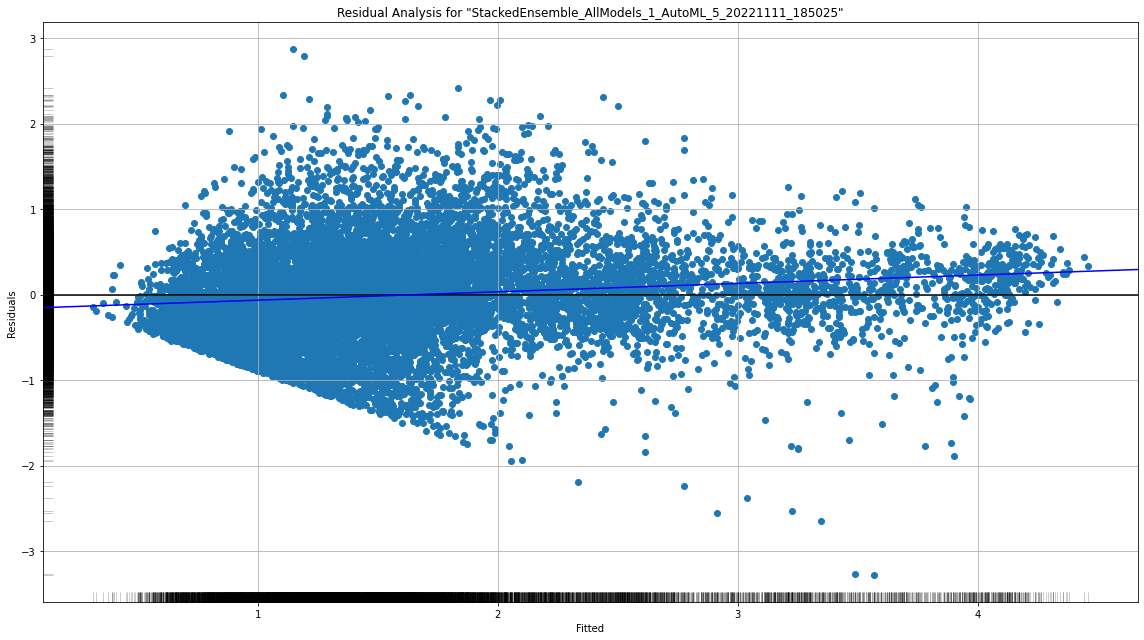

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

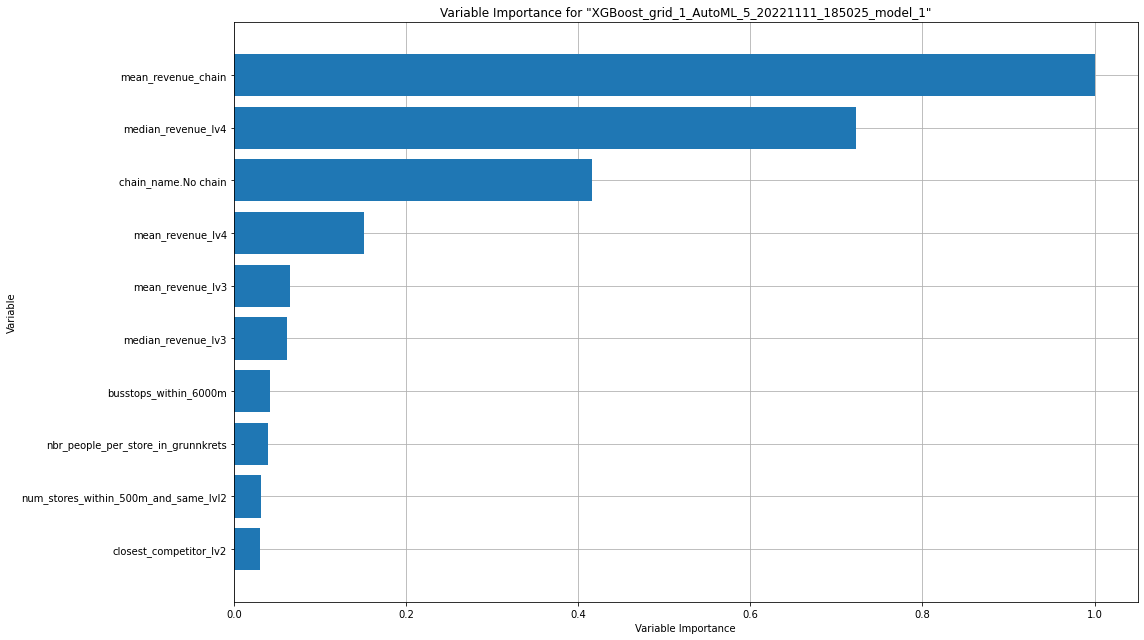

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

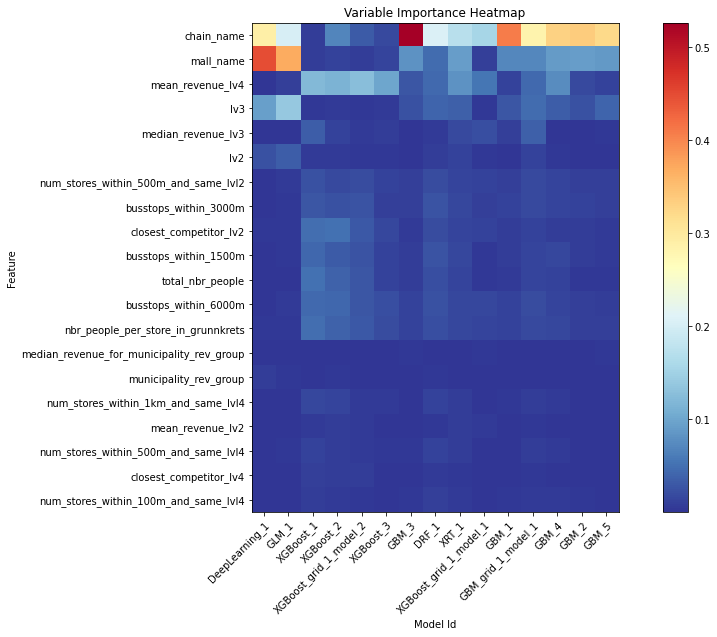

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

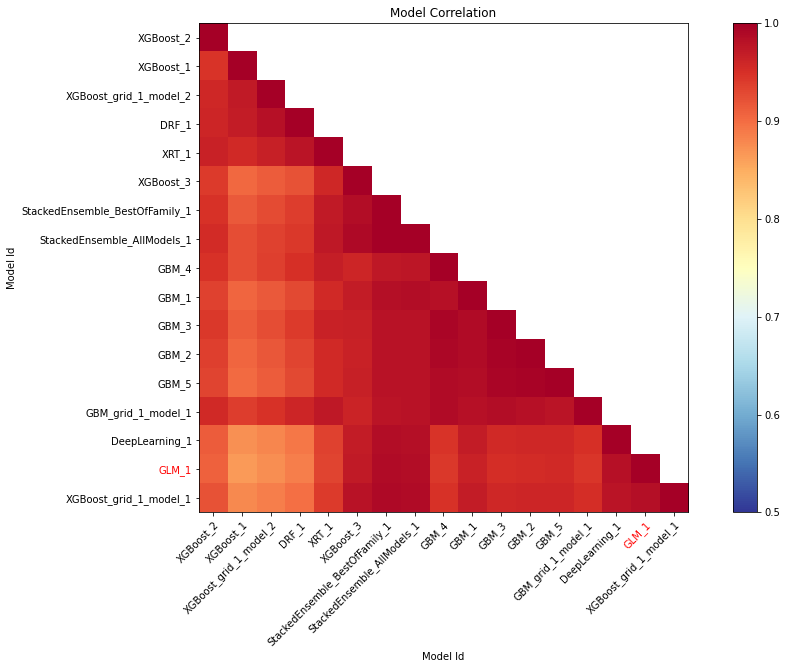

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

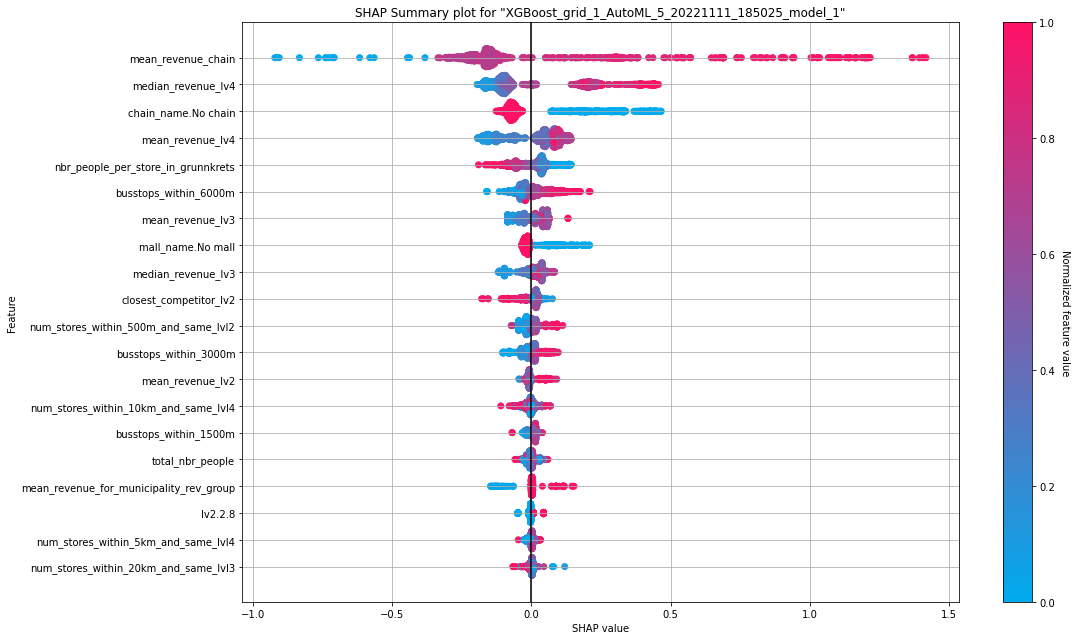

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

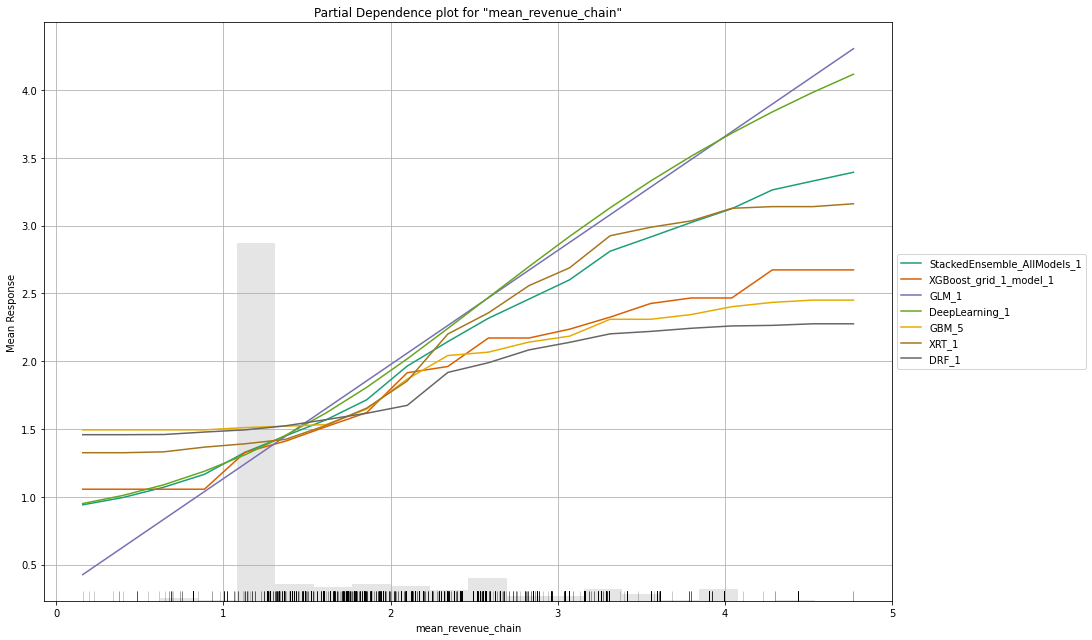

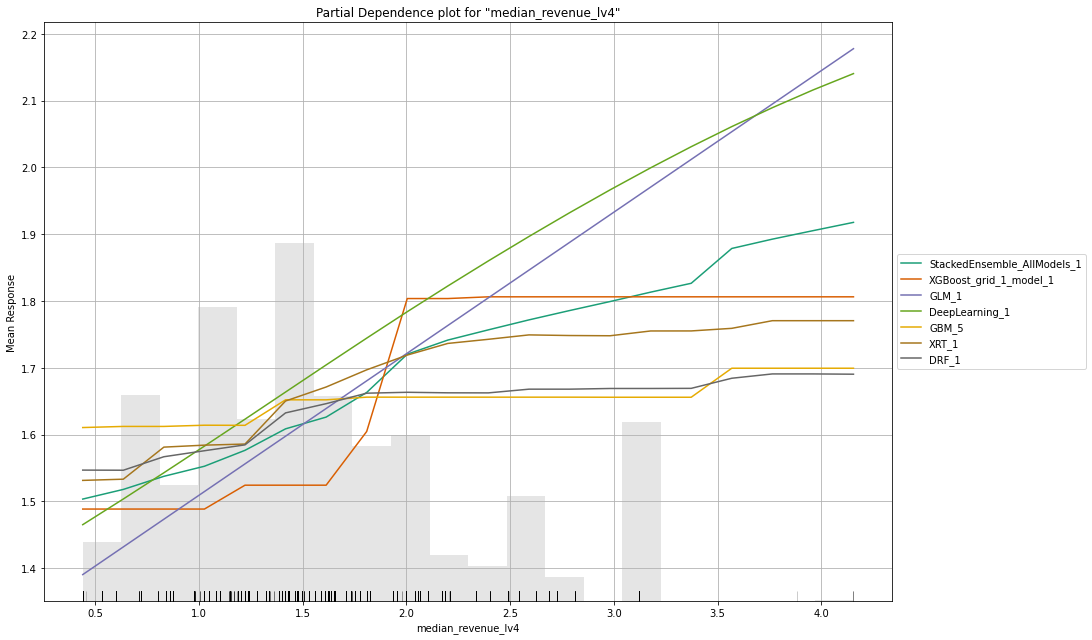

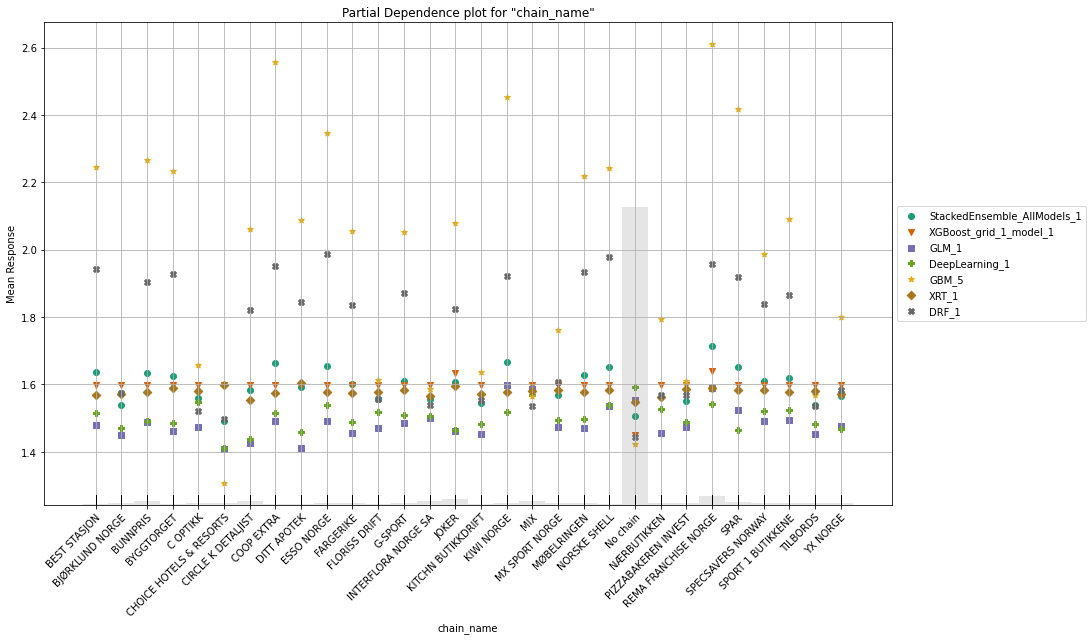

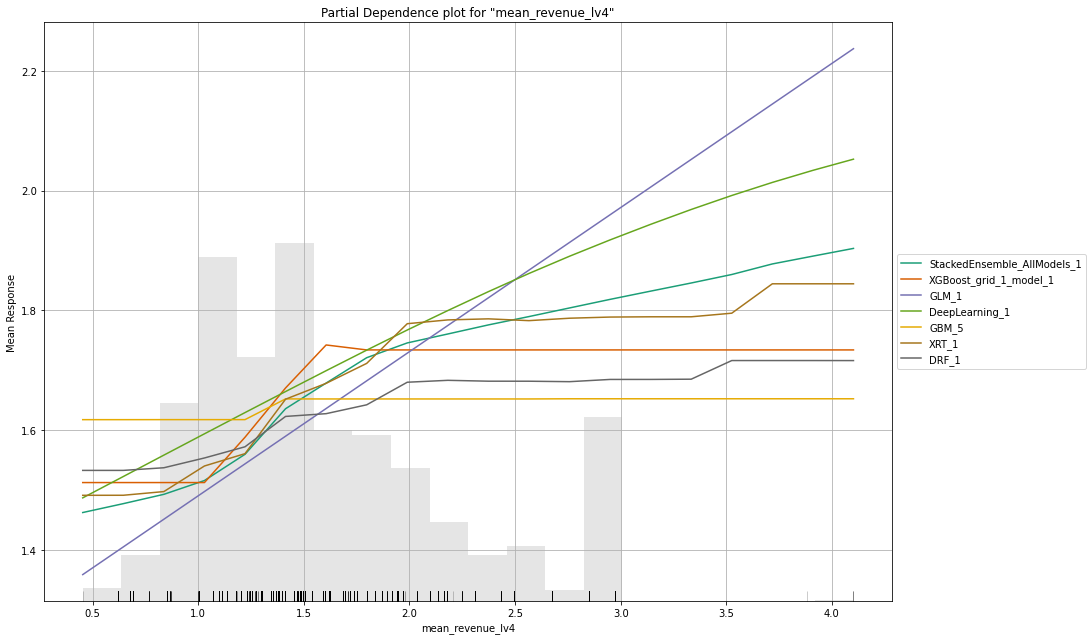

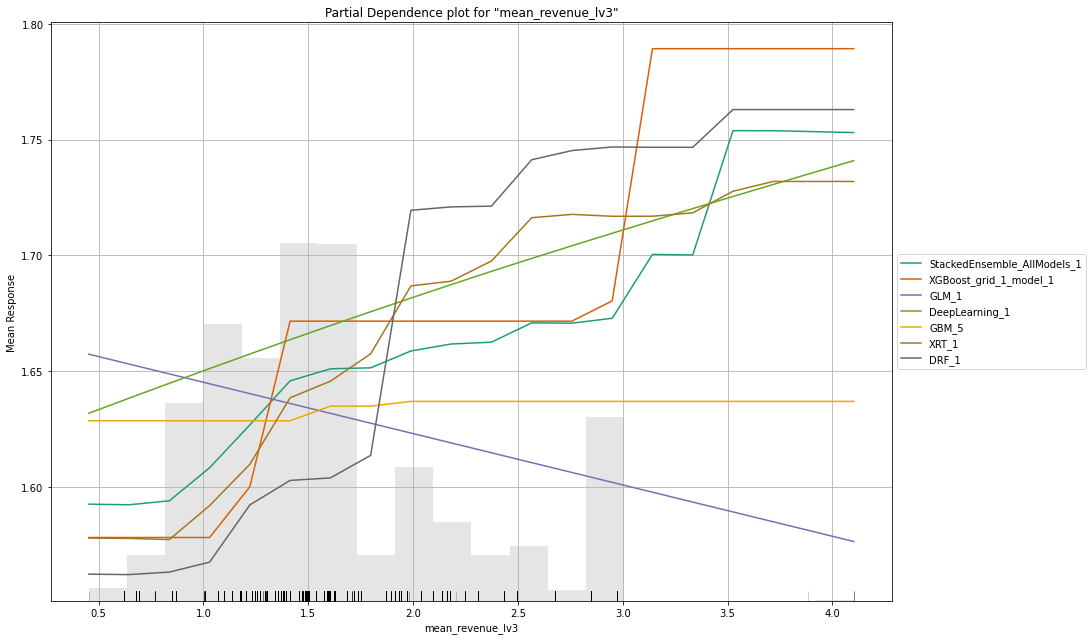

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

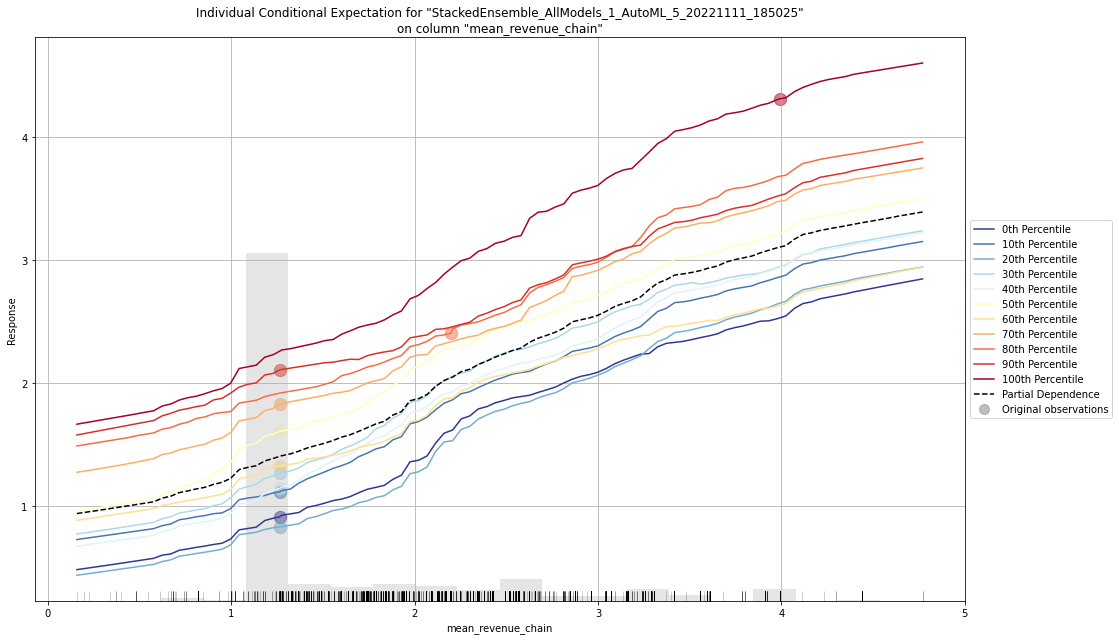

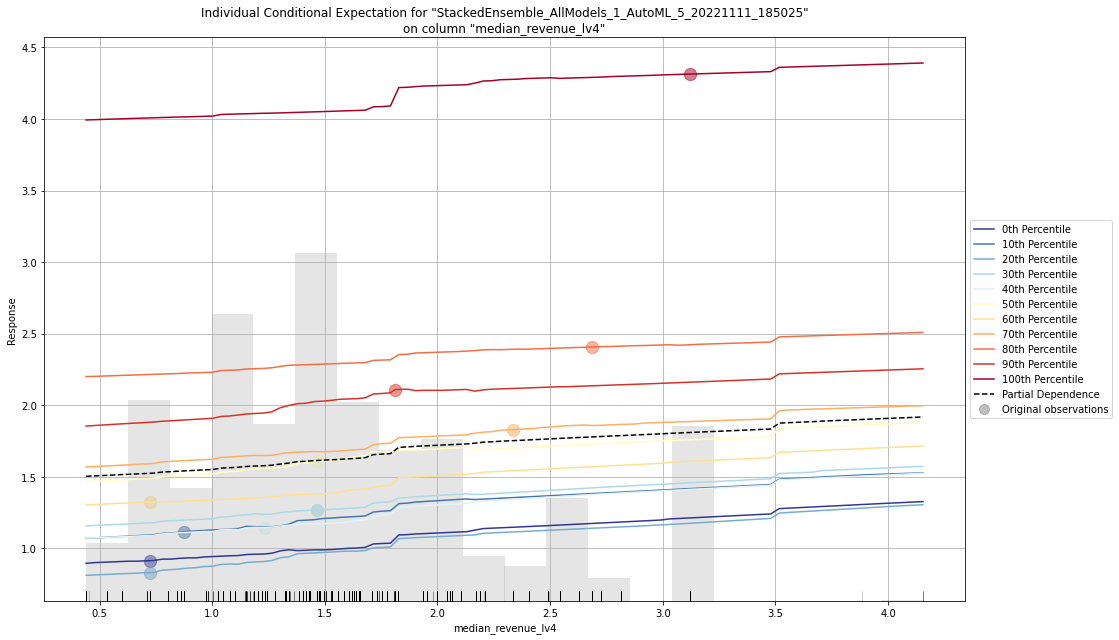

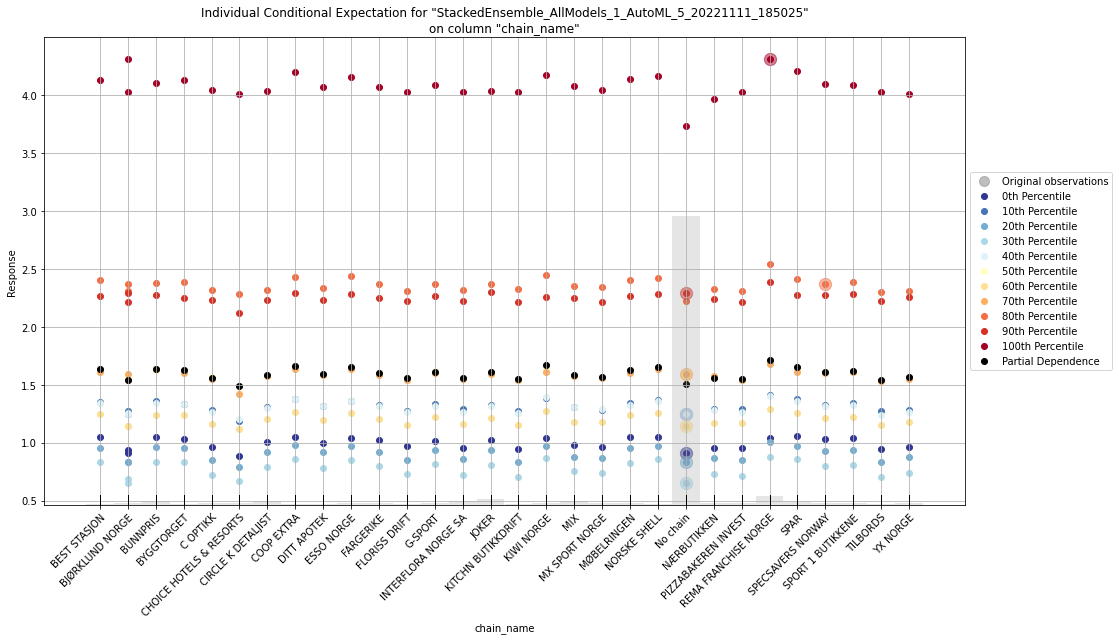

In [67]:
aml.explain(frame = train_data)